In [1]:
import math
import gc
import pickle
import random
from copy import deepcopy
from tqdm import tqdm
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
import optuna
from optuna.samplers import RandomSampler, TPESampler, GPSampler
import warnings
warnings.filterwarnings("ignore")
# import multiprocessing
# max_n_jobs = multiprocessing.cpu_count()
import shap
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, Sampler
import torch.nn as nn
import torch.optim as optim
import mlx.core as mx
import mlx.nn as nnmx
import mlx.optimizers as optimmx

/Users/justpqa/drw-crypto-market-prediction/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set the device
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [3]:
feature_version = 2
# 1 for pc feature, 
# 2 for label correlation feature # seems to work most consistently
# 3 for best features based on combination rank
# 4 for including time features (in case we want to reverse engineer the masked timestamp)
# 5 for increasing number of correlation features + only use those that are in the same cluster
# 6 is for 2 but more features, use when I want to use more features for larger models or AE approaches

In [4]:
default_random_state = 101
random.seed(default_random_state)
np.random.seed(default_random_state)
torch.manual_seed(default_random_state)
torch.mps.manual_seed(default_random_state)
mx.random.seed(default_random_state)

#### Import train data and popular features

In [5]:
train_df = pd.read_parquet(f"data/cleaned/cleaned_train_{feature_version}.parquet")
train_df.head()

,X751,X473,X472,X451,X226,X219,X205,X445,X444,X27,...,normalized_buy_volume,normalized_sell_volume,liquidity_adjusted_imbalance,pressure_spread_interaction,trade_direction_ratio,net_buy_volume,bid_skew,ask_skew,__index_level_0__,label
0,0.000617,0.362816,0.255354,0.625153,-0.893206,-0.654146,-1.250753,0.755891,0.625328,1.714323,...,11.542564,5.339347,0.063569,-0.230493,0.796810,131.421,0.644635,0.355365,2023-03-01 00:00:00,0.562539
1,0.013388,0.378391,0.274621,0.637250,-0.738291,-0.634723,-1.100357,0.760472,0.633046,1.396133,...,13.626484,137.821061,0.011610,-0.549445,0.620251,203.896,0.942921,0.057079,2023-03-01 00:01:00,0.533686
2,-0.016807,0.382337,0.279272,0.640437,-0.713420,-0.631882,-1.073226,0.761631,0.635009,1.205921,...,360.242073,2.263386,0.015877,0.530818,0.538664,22.858,0.007283,0.992717,2023-03-01 00:02:00,0.546505
3,-0.036622,0.387473,0.284750,0.642831,-0.644172,-0.612901,-0.982398,0.761936,0.635508,1.419536,...,69.011716,5.946089,0.025702,0.454780,0.728757,210.779,0.187976,0.812024,2023-03-01 00:03:00,0.357703
4,-0.053322,0.390820,0.289431,0.648175,-0.628840,-0.607648,-0.952145,0.764770,0.640311,1.408936,...,3.623647,12.867864,0.081042,-0.533689,0.689066,54.004,0.887255,0.112745,2023-03-01 00:04:00,0.362452


In [6]:
popular_features_train = pd.read_parquet("data/cleaned/popular_features_train.parquet")
popular_features_train.head()

,volume,bid_qty,ask_qty,buy_qty,sell_qty
0,221.389,15.283,8.425,176.405,44.984
1,847.796,38.590,2.336,525.846,321.950
2,295.596,0.442,60.250,159.227,136.369
3,460.705,4.865,21.016,335.742,124.963
4,142.818,27.158,3.451,98.411,44.407


#### Implement some helper function

In [7]:
# First need to split into some fold
train_df["__index_level_0__"] = pd.to_datetime(train_df["__index_level_0__"])

default_cv = 4
default_cv_type = "full"
# NOTE: default_cv must set to 1 instead of 3 based on consistency with LB score contains 49% of test data
# NOTE: 3 cv with gap is slightly better or almost equal

def create_cv(train_df, features=None, cv=default_cv):
    if features is not None:
        train_df = train_df[features + ["__index_level_0__", "label"]]
    X_train_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_test_arr = []
    for i in range(cv):
        # if i == 0:
        #     train_month = [3, 4, 5, 6, 7, 8]
        #     test_month = [9, 10, 11, 12, 1, 2]
        # else:
        train_month = list(range(3 + i, 7 + i))
        test_month = list(map(lambda x: x % 12 if x > 12 else x, list(range(8 + i, 12 + i))))
        print(train_month, test_month)
        # print(train_month, test_month)
        train = train_df[train_df["__index_level_0__"].dt.month.isin(train_month)].reset_index().drop("index", axis = 1)
        test = train_df[train_df["__index_level_0__"].dt.month.isin(test_month)].reset_index().drop("index", axis = 1)
        X_train_arr.append(train.drop(["__index_level_0__", "label"], axis = 1))
        X_test_arr.append(test.drop(["__index_level_0__", "label"], axis = 1))
        Y_train_arr.append(train["label"])
        Y_test_arr.append(test["label"])  
    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr

# def create_cv_random_test(train_df, features=None, test_cv=10):
#     # randomize so that we have 1 train, but try it on 10 different test 
#     if features is not None:
#         train_df = train_df[features + ["timestamp", "label"]]
#     X_train_arr = []
#     X_test_arr = []
#     Y_train_arr = []
#     Y_test_arr = []

#     # Create train data
#     train_month = [3, 4, 5, 6, 7, 8]
#     train = train_df[train_df["timestamp"].dt.month.isin(train_month)] 
#     X_train_arr.append(train.drop(["timestamp", "label"], axis = 1))
#     Y_train_arr.append(train["label"])

#     test_month = [9, 10, 11, 12, 1, 2]
#     test = train_df[train_df["timestamp"].dt.month.isin(test_month)]
#     # Create test data
#     for _ in range(test_cv):
#         random_test = test.sample(frac = 0.5, random_state = default_random_state)
#         X_test_arr.append(random_test.drop(["timestamp", "label"], axis = 1))
#         Y_test_arr.append(random_test["label"])

#     return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr 

# class [-1, 0, 1] -> [0, 1, 2] => < -0.2 => neg, > 0.2 => pos, else => neutral
def create_classification_class(label):
    if label < -0.4: return 0
    elif label < 0: return 1
    elif label < 0.4: return 2
    return 3

def create_cv_classification(train_df, features=None, cv=default_cv):
    if features is not None:
        train_df = train_df[features + ["__index_level_0__", "label"]]
    X_train_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_test_arr = []
    for i in range(cv):
        train_month = list(range(3 + i, 7 + i))
        # train_month = [3, 4, 5, 6, 7, 8]
        test_month = list(map(lambda x: x % 12 if x > 12 else x, list(range(8 + i, 12 + i))))
        print(train_month, test_month)
        # test_month = [9, 10, 11, 12, 1, 2] # try to make a gap to see if there is any differences in cv-lb correlation
        # print(train_month, test_month)
        train = train_df[train_df["__index_level_0__"].dt.month.isin(train_month)].reset_index().drop("index", axis = 1)
        test = train_df[train_df["__index_level_0__"].dt.month.isin(test_month)].reset_index().drop("index", axis = 1)
        X_train_arr.append(train.drop(["__index_level_0__", "label"], axis = 1))
        X_test_arr.append(test.drop(["__index_level_0__", "label"], axis = 1))
        Y_train_arr.append(train["label"].apply(lambda x: create_classification_class(x)))
        Y_test_arr.append(test["label"].apply(lambda x: create_classification_class(x)))  
    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr

In [8]:
def pearson_score(Y_test, Y_pred):
    if isinstance(Y_test, pd.Series) or isinstance(Y_test, pd.DataFrame):
        Y_test = Y_test.values
    if isinstance(Y_pred, pd.Series) or isinstance(Y_pred, pd.DataFrame):
        Y_pred = Y_pred.values
    Y_test = np.ravel(Y_test)
    Y_pred = np.ravel(Y_pred)
    pearson = np.corrcoef(Y_test, Y_pred)[0, 1]
    if np.isnan(pearson):
        if np.std(Y_pred) == 0:
            print(Y_pred)
            print("Error: zero variance prediction")
        elif np.isnan(Y_pred).any():
            print("Error: nan prediction")
        return -1
    else:
        return pearson

In [9]:
# Make function specifically for cross validation
def train_eval_cv(model, cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, scoring_function=pearson_score):
    cv_score = 0

    for i in range(cv):
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        cv_score += scoring_function(Y_test, Y_pred)
    
    return cv_score / cv

def train_eval_cv_random_test(model, cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, scoring_function=pearson_score, test_cv = 10):
    cv_score = 0

    for i in range(cv):
        curr_cv_score = 0

        # Conduct fitting
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        model.fit(X_train, Y_train)
        
        # sampling and testing
        len_test = X_test.shape[0]
        for seed in tqdm(range(test_cv)):
            np.random.seed(seed)
            test_index = np.random.choice(len_test, size = len_test // 2, replace = False) 
            X_test_sample = X_test.loc[test_index, :]
            Y_test_sample = Y_test[test_index]
            Y_pred_sample = model.predict(X_test_sample)
            curr_cv_score += scoring_function(Y_test_sample, Y_pred_sample)
        
        cv_score += curr_cv_score / test_cv
    
    np.random.seed(default_random_state)
    return cv_score

In [10]:
default_n_trees = 1000
# Finetuning XGBoost
def objective_xgboost(trial):
    params = {
        "n_estimators": default_n_trees,
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log = True), # 0.001 - 0.1 -> 0.01 - 0.05 
        "verbosity": 0,
        "subsample": trial.suggest_float("subsample", 0.05, 1.0), # 1.0 -> 0.2
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.05, 1), 
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1), 
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 100),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "enable_categorical": True,
        "random_state": default_random_state
    }

    xgbr = XGBRegressor(**params)
    cv_pearson = train_eval_cv(xgbr, default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, pearson_score)
    return cv_pearson

def objective_lightgbm(trial):
    params = {
        "n_estimators": default_n_trees,
        "verbosity": -1,
        "max_depth": trial.suggest_int("max_depth", 2, 10), # 1 - 10 => 1 - 5
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True), # 0.001 - 0.1 -> 0.005 - 0.02
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 0, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 100),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "random_state": default_random_state
    }

    lgbr = LGBMRegressor(**params)
    cv_pearson = train_eval_cv(lgbr, default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, pearson_score)
    return cv_pearson

def objective_catboost(trial):
    params = {
        "iterations": default_n_trees,
        "verbose": False,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True), # 0.001 - 0.1 => 0.01 - 0.1
        "depth": trial.suggest_int("depth", 1, 10), #  1 - 10 => 5 - 15
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 600),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "random_seed": default_random_state
    }

    cbr = CatBoostRegressor(**params)
    cv_pearson = train_eval_cv(cbr, default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, pearson_score)
    return cv_pearson

In [11]:
# Finetuning XGBoost
def objective_xgboost_classification(trial):
    params = {
        "n_estimators": default_n_trees,
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log = True), # 0.001 - 0.1 -> 0.01 - 0.05 
        "verbosity": 0,
        "subsample": trial.suggest_float("subsample", 0.05, 1.0), # 1.0 -> 0.2
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.05, 1), 
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1), 
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 100),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "enable_categorical": True,
        "random_state": default_random_state
    }

    xgbr = XGBClassifier(**params)
    cv_acc = train_eval_cv(xgbr, default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, accuracy_score)
    return cv_acc

def objective_lightgbm_classification(trial):
    params = {
        "n_estimators": default_n_trees,
        "verbosity": -1,
        "max_depth": trial.suggest_int("max_depth", 2, 10), # 1 - 10 => 1 - 5
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True), # 0.001 - 0.1 -> 0.005 - 0.02
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 0, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 100),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "random_state": default_random_state
    }

    lgbr = LGBMClassifier(**params)
    cv_acc = train_eval_cv(lgbr, default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, accuracy_score)
    return cv_acc

def objective_catboost_classification(trial):
    params = {
        "iterations": default_n_trees,
        "verbose": False,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True), # 0.001 - 0.1 => 0.01 - 0.1
        "depth": trial.suggest_int("depth", 1, 10), #  1 - 10 => 5 - 15
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 600),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "random_seed": default_random_state
    }

    cbr = CatBoostRegressor(**params)
    cv_acc = train_eval_cv(cbr, default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, accuracy_score)
    return cv_acc

In [12]:
default_n_trials = 100
default_n_jobs = 1

def optimize_xgboost(study_name, storage_name, objective_function=objective_xgboost, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for XGBoost")
    study = optuna.create_study(
        study_name = study_name,
        direction ='maximize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = TPESampler(seed = 101, n_startup_trials=10),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best Pearson score:', study.best_value)
    return study.best_params

def optimize_lightgbm(study_name, storage_name, objective_function=objective_lightgbm, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for LightGBM")
    study = optuna.create_study(
        study_name = study_name,
        direction='maximize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = TPESampler(seed = 101, n_startup_trials=10),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best Pearson score:', study.best_value)
    return study.best_params

def optimize_catboost(study_name, storage_name, objective_function=objective_catboost, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for CatBoost")
    study = optuna.create_study(
        study_name = study_name,
        direction='maximize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = TPESampler(seed = 101, n_startup_trials=10),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best Pearson score:', study.best_value)
    return study.best_params

#### First iteration: training with all features from the collection, no popular features

In [13]:
original_features = [f for f in train_df.columns if "X" in f]

X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_df, original_features)

[3, 4, 5, 6] [8, 9, 10, 11]
[4, 5, 6, 7] [9, 10, 11, 12]
[5, 6, 7, 8] [10, 11, 12, 1]
[6, 7, 8, 9] [11, 12, 1, 2]


In [14]:
best_params_xgboost = optimize_xgboost(
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study",
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study"
)

[I 2025-07-10 17:23:36,710] Using an existing study with name 'xgboost_2_4_101_1000_study' instead of creating a new one.


Conduct hyperparam opt for XGBoost


[I 2025-07-10 17:23:55,083] Trial 100 finished with value: 0.08961697859719414 and parameters: {'max_depth': 4, 'learning_rate': 0.003712628630987795, 'subsample': 0.12903693718952244, 'colsample_bytree': 0.8021294368194642, 'colsample_bynode': 0.9765075984142312, 'colsample_bylevel': 0.43564165247393294, 'min_child_weight': 4, 'reg_alpha': 49.654967064583644, 'reg_lambda': 45.82458500428814, 'gamma': 1.7122859258975827}. Best is trial 22 with value: 0.09493990296011455.
[I 2025-07-10 17:24:21,640] Trial 101 finished with value: 0.09172485540139552 and parameters: {'max_depth': 6, 'learning_rate': 0.004915673408913428, 'subsample': 0.0964113379543062, 'colsample_bytree': 0.8848920215256009, 'colsample_bynode': 0.9606877764634342, 'colsample_bylevel': 0.6342600806000078, 'min_child_weight': 2, 'reg_alpha': 52.98961092849662, 'reg_lambda': 42.283501595430366, 'gamma': 0.7167384172359805}. Best is trial 22 with value: 0.09493990296011455.
[I 2025-07-10 17:24:48,856] Trial 102 finished wit

Best hyperparameters: {'max_depth': 5, 'learning_rate': 0.009157115761031804, 'subsample': 0.050524287149523256, 'colsample_bytree': 0.9761755456495413, 'colsample_bynode': 0.8151812600468186, 'colsample_bylevel': 0.6447498496343692, 'min_child_weight': 4, 'reg_alpha': 23.104580872347558, 'reg_lambda': 58.5437229140396, 'gamma': 0.10460988905630547}
Best Pearson score: 0.09665037517773095


In [15]:
best_params_lightgbm = optimize_lightgbm(
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study",
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study"
)

[I 2025-07-10 18:04:16,430] Using an existing study with name 'lightgbm_2_4_101_1000_study' instead of creating a new one.


Conduct hyperparam opt for LightGBM


[I 2025-07-10 18:05:02,539] Trial 100 finished with value: 0.07892859541305247 and parameters: {'max_depth': 6, 'learning_rate': 0.012371188952488739, 'num_leaves': 1021, 'subsample': 0.49596637971065266, 'colsample_bytree': 0.39537258409755, 'min_child_weight': 0.6370207216728078, 'reg_alpha': 31.69516386557367, 'reg_lambda': 59.75510275906909}. Best is trial 59 with value: 0.08271432376475601.
[I 2025-07-10 18:06:12,364] Trial 101 finished with value: 0.077326138410957 and parameters: {'max_depth': 7, 'learning_rate': 0.008629505600414382, 'num_leaves': 975, 'subsample': 0.4145104994292647, 'colsample_bytree': 0.3327024045759099, 'min_child_weight': 0.5443800014914199, 'reg_alpha': 39.10762490476717, 'reg_lambda': 51.46901651483939}. Best is trial 59 with value: 0.08271432376475601.
[I 2025-07-10 18:07:20,165] Trial 102 finished with value: 0.08177007971645159 and parameters: {'max_depth': 7, 'learning_rate': 0.009950251919582844, 'num_leaves': 874, 'subsample': 0.4259687149688191, '

Best hyperparameters: {'max_depth': 7, 'learning_rate': 0.00551050415008201, 'num_leaves': 686, 'subsample': 0.19166703753238232, 'colsample_bytree': 0.6190543322851022, 'min_child_weight': 0.45732209154347087, 'reg_alpha': 97.98770106886175, 'reg_lambda': 60.408051711022694}
Best Pearson score: 0.08515053076565988


In [ ]:
# best_params_catboost = optimize_catboost(
#     f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study",
#     f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study"
# )
# # Need to take down as catboost might not work well in this situation

Analyze params - cv relationship

In [13]:
def get_study_df(filename):
    study = optuna.load_study(
        study_name = filename,
        storage = f"sqlite:///{filename}.db"
    )
    study_df = []
    for trial in study.trials:
        trial_dict = trial.params
        trial_dict["value"] = trial.value
        study_df.append(trial_dict)

    return pd.DataFrame(study_df)

In [14]:
def params_value_viz(study_df):
    nrows = (study_df.shape[1] - 1) // 3 + ((study_df.shape[1] - 1) % 3 > 0)
    fig, ax = plt.subplots(nrows = nrows, ncols = 3, figsize = (14, 5 * nrows))
    for inx, var in enumerate(study_df.columns):
        x, y = inx // 3, inx % 3
        if var != "value":
            sns.regplot(study_df, x = var, y = "value", ax = ax[x][y], lowess=True, line_kws={'color': 'green'}, ci = 95)
    plt.show()

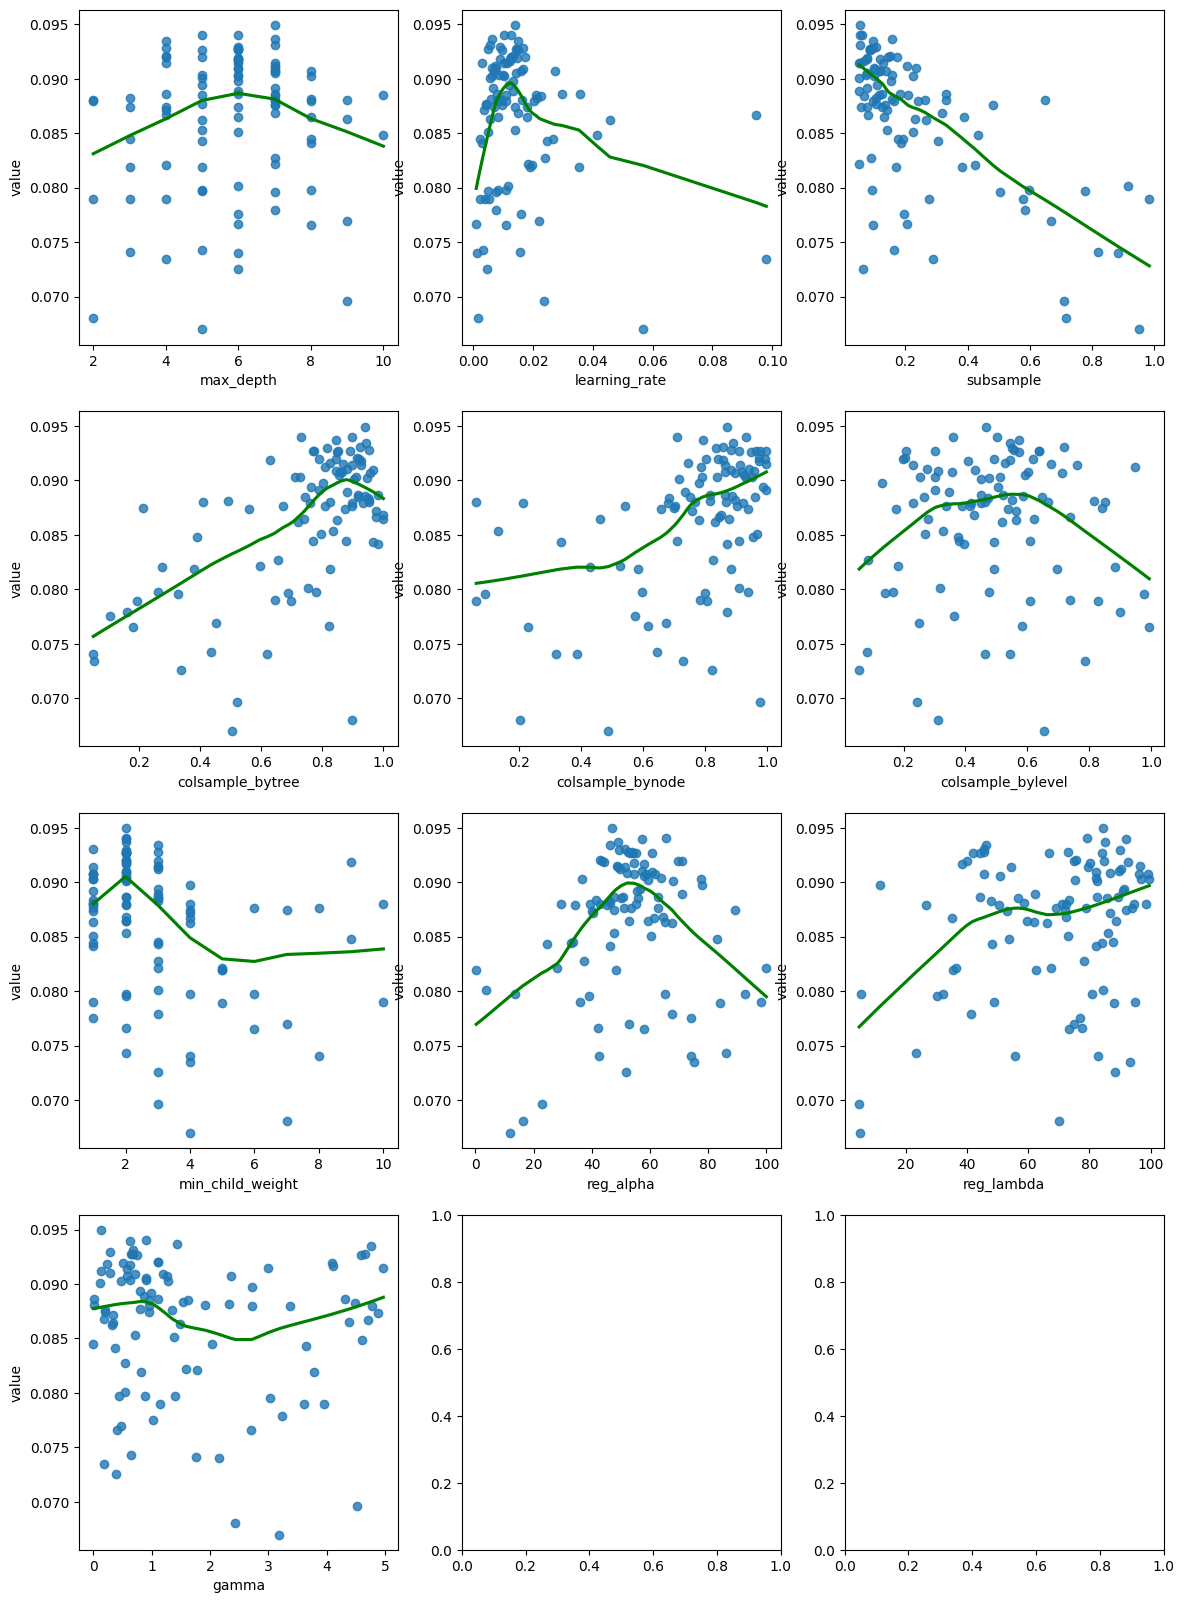

In [15]:
study_df_xgboost = get_study_df(f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")   
params_value_viz(study_df_xgboost)

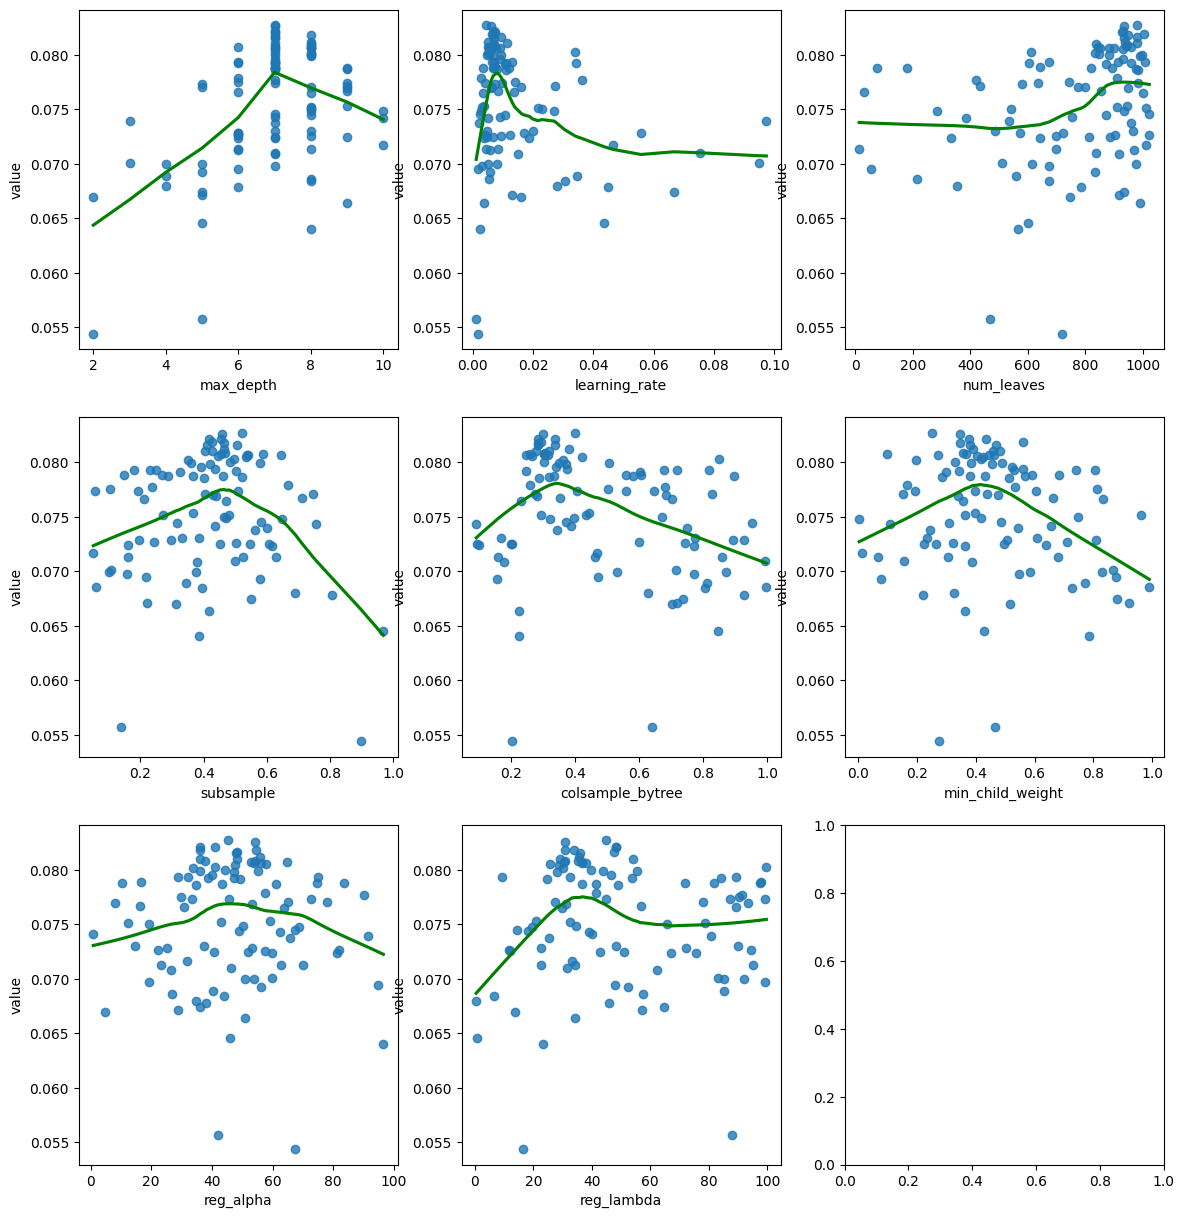

In [16]:
study_df_lightgbm = get_study_df(f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")
params_value_viz(study_df_lightgbm)

In [ ]:
# study_df_catboost = get_study_df(f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")
# params_value_viz(study_df_catboost)

Analyze feature importance + CV performance

In [15]:
def get_best_params_from_file(filename):
    study = optuna.load_study(
        study_name = filename,
        storage = f"sqlite:///{filename}.db"
    )
    return study.best_params

In [16]:
def get_shap_values(model, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, sample_size=10000):
    mean_abs_shap_all = np.zeros(X_train_arr[0].shape[1])
    for i in range(default_cv):
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        model.fit(X_train, Y_train)
        X_test_sample = X_test.sample(sample_size, random_state = default_random_state)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        mean_abs_shap = np.mean(np.abs(shap_values), axis = 0)
        mean_abs_shap_all += mean_abs_shap
    mean_abs_shap_all /= default_cv
    return mean_abs_shap_all

In [ ]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": default_random_state
}
best_params_xgboost = get_best_params_from_file(f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")
for p in best_params_xgboost:
    params[p] = best_params_xgboost[p]

xgboost_feature_importances = {}

xgbr = XGBRegressor(**params)
for i in range(default_cv):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    xgbr.fit(X_train, Y_train)
    print(pearson_score(Y_test, xgbr.predict(X_test)))
    features = xgbr.feature_names_in_.tolist()
    # features_i = xgbr.feature_importances_.tolist()
    features_i = get_shap_values(xgbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        xgboost_feature_importances[feat] = xgboost_feature_importances.get(feat, 0) + features_i[inx]

# print(feature_importances)
plt.hist(xgboost_feature_importances.values())
# Seems like only COD features are important (can try to only use 4-8 hours if 4-13 hours does not work well)

In [ ]:
print([f for f in xgboost_feature_importances if xgboost_feature_importances[f] > 0.01])

In [ ]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": -1,
    "random_state": default_random_state
}
best_params_lightgbm = get_best_params_from_file(f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")
for p in best_params_lightgbm:
    params[p] = best_params_lightgbm[p]

lightgbm_feature_importances = {}

lgbr = LGBMRegressor(**params)
for i in range(default_cv):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    lgbr.fit(X_train, Y_train)
    print(pearson_score(Y_test, lgbr.predict(X_test)))
    features = lgbr.feature_names_in_.tolist()
    # features_i = lgbr.feature_importances_.tolist()
    features_i = get_shap_values(lgbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        lightgbm_feature_importances[feat] = lightgbm_feature_importances.get(feat, 0) + features_i[inx]

plt.hist(lightgbm_feature_importances.values())
# seems to pick up time features not as good as past 4 hours features

In [ ]:
print([f for f in lightgbm_feature_importances if lightgbm_feature_importances[f] >= 0.01])

In [ ]:
# params = {
#     "iterations": default_n_trees,
#     "verbose": False,
#     "random_seed": default_random_state
# }
# best_params_catboost = get_best_params_from_file(f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")
# for p in best_params_catboost:
#     params[p] = best_params_catboost[p]

# catboost_feature_importances = {}

# cbr = CatBoostRegressor(**params)
# cv_rmse = 0

# for i in range(default_cv):
#     X_train, X_test = X_train_arr[i], X_test_arr[i]
#     Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
#     cbr.fit(X_train, Y_train)
#     print(pearson_score(Y_test, cbr.predict(X_test)))
#     features = cbr.feature_names_
#     # features_i = cbr.feature_importances_.tolist()
#     features_i = get_shap_values(cbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
#     for inx, feat in enumerate(features):
#         catboost_feature_importances[feat] = catboost_feature_importances.get(feat, 0) + features_i[inx]

# plt.hist(catboost_feature_importances.values())
# # can pick up a combination of both past cod and tss, not good at picking up ph, temp

In [ ]:
# print([f for f in catboost_feature_importances if catboost_feature_importances[f] >= 0.02])

Get top 20 important features in all of them

In [ ]:
xgboost_feature_importances_df = pd.DataFrame(
    {"var": xgboost_feature_importances.keys(), "importance": xgboost_feature_importances.values()}
)
xgboost_feature_importances_df["importance"] /= default_cv
# xgboost_feature_importances_df["rank_importance"] = xgboost_feature_importances_df["importance"].rank(ascending=False)
lightgbm_feature_importances_df = pd.DataFrame(
    {"var": lightgbm_feature_importances.keys(), "importance": lightgbm_feature_importances.values()}
)
lightgbm_feature_importances_df["importance"] /= default_cv
# lightgbm_feature_importances_df["rank_importance"] = lightgbm_feature_importances_df["importance"].rank(ascending=False)
# catboost_feature_importances_df = pd.DataFrame(
#     {"var": catboost_feature_importances.keys(), "importance_catboost": catboost_feature_importances.values()}
# )
# catboost_feature_importances_df["rank_importance"] = catboost_feature_importances_df["importance_catboost"].rank(ascending=False)
feature_importances_df = xgboost_feature_importances_df.merge(
    lightgbm_feature_importances_df,
    on="var",
    how="inner",
    suffixes=("_xgboost", "_lightgbm")
)
# feature_importances_df = feature_importances_df.merge(
#     catboost_feature_importances_df,
#     on="var",
#     how="inner",
#     suffixes=("", "_catboost")
# )
# feature_importances_df = feature_importances_df[["var", "rank_importance_xgboost", "rank_importance_lightgbm", "rank_importance_catboost"]]
# feature_importances_df["rank"] = 1/3 * (feature_importances_df["rank_importance_xgboost"] + feature_importances_df["rank_importance_lightgbm"] + feature_importances_df["rank_importance_catboost"])

feature_importances_df["importance"] = 1/2 * (feature_importances_df["importance_xgboost"] + feature_importances_df["importance_lightgbm"])
feature_importances_df = feature_importances_df.sort_values(by="importance", ascending=False).reset_index().drop("index", axis = 1)
feature_importances_df[:50]

In [ ]:
feature_importances_df.to_csv("feature_importances_df.csv", index = False)

In [ ]:
feature_importances_df = pd.read_csv("feature_importances_df.csv")
feature_importances_df

In [ ]:
print(feature_importances_df.loc[:49, "var"].tolist())

#### Second Iteration: adding popular feature in addition to original features correlated to label

In [17]:
train_added_df = pd.concat([train_df, popular_features_train], axis = 1)

X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_added_df)

[3, 4, 5, 6] [8, 9, 10, 11]
[4, 5, 6, 7] [9, 10, 11, 12]
[5, 6, 7, 8] [10, 11, 12, 1]
[6, 7, 8, 9] [11, 12, 1, 2]


In [21]:
best_params_xgboost_popular_feature = optimize_xgboost(
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_popular_feature_study",
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_popular_feature_study"
)

[I 2025-07-10 20:01:50,358] Using an existing study with name 'xgboost_2_4_101_1000_popular_feature_study' instead of creating a new one.


Conduct hyperparam opt for XGBoost


[I 2025-07-10 20:02:13,516] Trial 100 finished with value: 0.09047191266330812 and parameters: {'max_depth': 2, 'learning_rate': 0.027265725419807083, 'subsample': 0.1558685872136899, 'colsample_bytree': 0.914978266989195, 'colsample_bynode': 0.17524695340769575, 'colsample_bylevel': 0.8948287766890213, 'min_child_weight': 4, 'reg_alpha': 51.784439185695106, 'reg_lambda': 92.3998947097129, 'gamma': 0.8612047123538392}. Best is trial 42 with value: 0.09151615944529107.
[I 2025-07-10 20:02:35,752] Trial 101 finished with value: 0.08640130669501626 and parameters: {'max_depth': 2, 'learning_rate': 0.027229405870738924, 'subsample': 0.15852021945651645, 'colsample_bytree': 0.9146953074755342, 'colsample_bynode': 0.17104963129807776, 'colsample_bylevel': 0.8103170708666594, 'min_child_weight': 3, 'reg_alpha': 53.249488435565276, 'reg_lambda': 93.6198190964956, 'gamma': 0.9791049460590853}. Best is trial 42 with value: 0.09151615944529107.
[I 2025-07-10 20:02:58,683] Trial 102 finished with 

Best hyperparameters: {'max_depth': 2, 'learning_rate': 0.023822412492687513, 'subsample': 0.07095932765284871, 'colsample_bytree': 0.7341249111790842, 'colsample_bynode': 0.19497995167056037, 'colsample_bylevel': 0.8394846359636394, 'min_child_weight': 2, 'reg_alpha': 74.07922638699999, 'reg_lambda': 84.11761552622845, 'gamma': 0.4307028021784206}
Best Pearson score: 0.09336423955875577


In [22]:
best_params_lightgbm_popular_feature = optimize_lightgbm(
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_popular_feature_study",
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_popular_feature_study"
)

[I 2025-07-10 20:41:53,732] Using an existing study with name 'lightgbm_2_4_101_1000_popular_feature_study' instead of creating a new one.


Conduct hyperparam opt for LightGBM


[I 2025-07-10 20:43:10,104] Trial 100 finished with value: 0.0739702975365254 and parameters: {'max_depth': 7, 'learning_rate': 0.0036480855575958663, 'num_leaves': 506, 'subsample': 0.05122781195766579, 'colsample_bytree': 0.49635773712528775, 'min_child_weight': 0.7061851837526965, 'reg_alpha': 49.75520572629649, 'reg_lambda': 4.736264567942008}. Best is trial 84 with value: 0.08411040739228837.
[I 2025-07-10 20:44:30,327] Trial 101 finished with value: 0.08155859756106293 and parameters: {'max_depth': 7, 'learning_rate': 0.0068225080411404146, 'num_leaves': 610, 'subsample': 0.07763706637796686, 'colsample_bytree': 0.5495948472935731, 'min_child_weight': 0.49471576827536445, 'reg_alpha': 60.05255971115683, 'reg_lambda': 34.188639702888494}. Best is trial 84 with value: 0.08411040739228837.
[I 2025-07-10 20:46:22,552] Trial 102 finished with value: 0.0821997411863605 and parameters: {'max_depth': 8, 'learning_rate': 0.005989427519810147, 'num_leaves': 639, 'subsample': 0.106441150642

Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.01299170485426835, 'num_leaves': 855, 'subsample': 0.27478505815800014, 'colsample_bytree': 0.5267106945396373, 'min_child_weight': 0.9474486005040084, 'reg_alpha': 89.95768025111131, 'reg_lambda': 99.86683249638935}
Best Pearson score: 0.08699767472013734


Check for feature importance

0.08511620589586051
0.09298576048668068
0.09982932473571703
0.09552566711676487


(array([72., 36., 19.,  5.,  1.,  2.,  1.,  2.,  1.,  1.]),
 array([0.        , 0.01921056, 0.03842112, 0.05763168, 0.07684225,
        0.09605281, 0.11526337, 0.13447393, 0.15368449, 0.17289505,
        0.19210561]),
 <BarContainer object of 10 artists>)

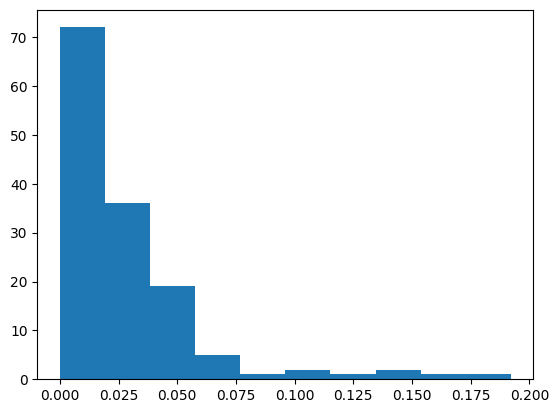

In [18]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": default_random_state
}
best_params_xgboost_popular_feature = get_best_params_from_file(f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_popular_feature_study")
for p in best_params_xgboost_popular_feature:
    params[p] = best_params_xgboost_popular_feature[p]

xgboost_feature_importances = {}

xgbr = XGBRegressor(**params)
for i in range(default_cv):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    xgbr.fit(X_train, Y_train)
    print(pearson_score(Y_test, xgbr.predict(X_test)))
    features = xgbr.feature_names_in_.tolist()
    # features_i = xgbr.feature_importances_.tolist()
    features_i = get_shap_values(xgbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        xgboost_feature_importances[feat] = xgboost_feature_importances.get(feat, 0) + features_i[inx]

# print(feature_importances)
plt.hist(xgboost_feature_importances.values())
# Seems like only COD features are important (can try to only use 4-8 hours if 4-13 hours does not work well)

0.09729093313779594
0.07643828455829914
0.10089976747839544
0.07336171370605882


(array([76., 34., 16.,  2.,  6.,  2.,  1.,  1.,  0.,  2.]),
 array([0.        , 0.02711503, 0.05423005, 0.08134508, 0.10846011,
        0.13557514, 0.16269016, 0.18980519, 0.21692022, 0.24403524,
        0.27115027]),
 <BarContainer object of 10 artists>)

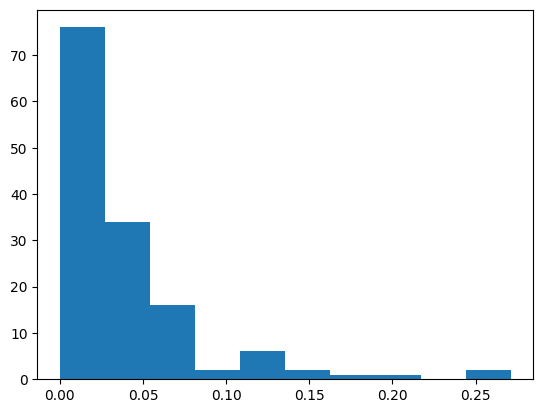

In [19]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": -1,
    "random_state": default_random_state
}
best_params_lightgbm_popular_feature = get_best_params_from_file(f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_popular_feature_study")
for p in best_params_lightgbm_popular_feature:
    params[p] = best_params_lightgbm_popular_feature[p]

lightgbm_feature_importances = {}

lgbr = LGBMRegressor(**params)
for i in range(default_cv):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    lgbr.fit(X_train, Y_train)
    print(pearson_score(Y_test, lgbr.predict(X_test)))
    features = lgbr.feature_names_in_.tolist()
    # features_i = lgbr.feature_importances_.tolist()
    features_i = get_shap_values(lgbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        lightgbm_feature_importances[feat] = lightgbm_feature_importances.get(feat, 0) + features_i[inx]

plt.hist(lightgbm_feature_importances.values())
# seems to pick up time features not as good as past 4 hours features

In [20]:
xgboost_feature_importances_df = pd.DataFrame(
    {"var": xgboost_feature_importances.keys(), "importance": xgboost_feature_importances.values()}
)
xgboost_feature_importances_df["importance"] /= default_cv
# xgboost_feature_importances_df["rank_importance"] = xgboost_feature_importances_df["importance"].rank(ascending=False)
lightgbm_feature_importances_df = pd.DataFrame(
    {"var": lightgbm_feature_importances.keys(), "importance": lightgbm_feature_importances.values()}
)
lightgbm_feature_importances_df["importance"] /= default_cv
# lightgbm_feature_importances_df["rank_importance"] = lightgbm_feature_importances_df["importance"].rank(ascending=False)
# catboost_feature_importances_df = pd.DataFrame(
#     {"var": catboost_feature_importances.keys(), "importance_catboost": catboost_feature_importances.values()}
# )
# catboost_feature_importances_df["rank_importance"] = catboost_feature_importances_df["importance_catboost"].rank(ascending=False)
feature_importances_df = xgboost_feature_importances_df.merge(
    lightgbm_feature_importances_df,
    on="var",
    how="inner",
    suffixes=("_xgboost", "_lightgbm")
)
# feature_importances_df = feature_importances_df.merge(
#     catboost_feature_importances_df,
#     on="var",
#     how="inner",
#     suffixes=("", "_catboost")
# )
# feature_importances_df = feature_importances_df[["var", "rank_importance_xgboost", "rank_importance_lightgbm", "rank_importance_catboost"]]
# feature_importances_df["rank"] = 1/3 * (feature_importances_df["rank_importance_xgboost"] + feature_importances_df["rank_importance_lightgbm"] + feature_importances_df["rank_importance_catboost"])
feature_importances_df["importance"] = 1/2 * (feature_importances_df["importance_xgboost"] + feature_importances_df["importance_lightgbm"])
feature_importances_df = feature_importances_df.sort_values(by="importance", ascending=False).reset_index().drop("index", axis = 1)
feature_importances_df

,var,importance_xgboost,importance_lightgbm,importance
0,X757,0.038198,0.067788,0.052993
1,X758,0.035309,0.064893,0.050101
2,X759,0.048026,0.042903,0.045465
3,X508,0.024835,0.047838,0.036336
4,X614,0.042196,0.029092,0.035644
...,...,...,...,...
135,trade_intensity,0.000000,0.000184,0.000092
136,bid_skew,0.000174,0.000000,0.000087
137,spread_indicator,0.000079,0.000000,0.000039
138,avg_trade_size,0.000000,0.000048,0.000024


In [21]:
best_xgboost_score = optuna.load_study(
    study_name = "xgboost_2_4_101_1000_popular_feature_study",
    storage = f"sqlite:///xgboost_2_4_101_1000_popular_feature_study.db"
).best_value
best_lightgbm_score = optuna.load_study(
    study_name = "lightgbm_2_4_101_1000_popular_feature_study",
    storage = f"sqlite:///lightgbm_2_4_101_1000_popular_feature_study.db"
).best_value
feature_importances_df["weighted_importance"] = (best_xgboost_score * feature_importances_df["importance_xgboost"] + best_lightgbm_score * feature_importances_df["importance_lightgbm"]) / (best_xgboost_score + best_lightgbm_score)
feature_importances_df = feature_importances_df.sort_values("weighted_importance", ascending=False, ignore_index=True)
feature_importances_df

,var,importance_xgboost,importance_lightgbm,importance,weighted_importance
0,X757,0.038198,0.067788,0.052993,0.052471
1,X758,0.035309,0.064893,0.050101,0.049579
2,X759,0.048026,0.042903,0.045465,0.045555
3,X508,0.024835,0.047838,0.036336,0.035930
4,X614,0.042196,0.029092,0.035644,0.035876
...,...,...,...,...,...
135,bid_skew,0.000174,0.000000,0.000087,0.000090
136,trade_intensity,0.000000,0.000184,0.000092,0.000089
137,spread_indicator,0.000079,0.000000,0.000039,0.000041
138,avg_trade_size,0.000000,0.000048,0.000024,0.000023


In [22]:
feature_importances_df.to_csv("feature_importances_df.csv", index = False)

In [22]:
feature_importances_df = pd.read_csv("feature_importances_df.csv")
feature_importances_df

,var,importance_xgboost,importance_lightgbm,importance,weighted_importance
0,X757,0.038198,0.067788,0.052993,0.052471
1,X758,0.035309,0.064893,0.050101,0.049579
2,X759,0.048026,0.042903,0.045465,0.045555
3,X508,0.024835,0.047838,0.036336,0.035930
4,X614,0.042196,0.029092,0.035644,0.035876
...,...,...,...,...,...
135,bid_skew,0.000174,0.000000,0.000087,0.000090
136,trade_intensity,0.000000,0.000184,0.000092,0.000089
137,spread_indicator,0.000079,0.000000,0.000039,0.000041
138,avg_trade_size,0.000000,0.000048,0.000024,0.000023


In [23]:
feature_importances_df[~feature_importances_df["var"].str.contains("X")]

,var,importance_xgboost,importance_lightgbm,importance,weighted_importance
100,order_flow_imbalance,0.000783,2.226598e-03,0.001505,0.001479
101,realized_volatility_proxy,0.000544,2.035748e-03,0.001290,0.001263
102,sell_qty,0.001914,2.555699e-04,0.001085,0.001114
103,volume_weighted_sell,0.001726,2.038325e-04,0.000965,0.000992
104,volume_participation,0.001860,5.947269e-05,0.000960,0.000992
105,buy_sell_ratio,0.000617,1.345159e-03,0.000981,0.000968
106,depth_ratio,0.001733,1.103934e-04,0.000922,0.000950
107,selling_pressure,0.000776,1.086897e-03,0.000931,0.000926
108,bid_buy_interaction,0.001394,2.837906e-04,0.000839,0.000858
109,buy_sell_interaction,0.001304,3.561274e-04,0.000830,0.000847


In [24]:
print(feature_importances_df.sort_values("importance", ignore_index=True, ascending=False).head(20)["var"].tolist())

['X757', 'X758', 'X759', 'X508', 'X614', 'X752', 'X331', 'X445', 'X465', 'X385', 'X466', 'X95', 'X23', 'X219', 'X31', 'X373', 'X379', 'X284', 'X750', 'X652']


In [25]:
print(feature_importances_df.sort_values("weighted_importance", ignore_index=True, ascending=False).head(20)["var"].tolist())

['X757', 'X758', 'X759', 'X508', 'X614', 'X752', 'X331', 'X445', 'X465', 'X385', 'X466', 'X95', 'X23', 'X31', 'X219', 'X373', 'X379', 'X284', 'X750', 'X652']


In [26]:
s1 = set(feature_importances_df.sort_values("importance", ignore_index=True, ascending=False).head(20)["var"].tolist())
s2 = set(feature_importances_df.sort_values("weighted_importance", ignore_index=True, ascending=False).head(20)["var"].tolist())
print(s1 - s2)
print(s2 - s1)

set()
set()


In [27]:
feature_importances_df.sort_values("importance", ignore_index=True, ascending=False).head(50)

,var,importance_xgboost,importance_lightgbm,importance,weighted_importance
0,X757,0.038198,0.067788,0.052993,0.052471
1,X758,0.035309,0.064893,0.050101,0.049579
2,X759,0.048026,0.042903,0.045465,0.045555
3,X508,0.024835,0.047838,0.036336,0.035930
4,X614,0.042196,0.029092,0.035644,0.035876
5,X752,0.028826,0.037114,0.032970,0.032824
6,X331,0.025990,0.030190,0.028090,0.028016
7,X445,0.018680,0.037346,0.028013,0.027683
8,X465,0.023904,0.030560,0.027232,0.027114
9,X385,0.018038,0.028484,0.023261,0.023076


In [28]:
feature_importances_df.sort_values("weighted_importance", ignore_index=True, ascending=False).head(50)

,var,importance_xgboost,importance_lightgbm,importance,weighted_importance
0,X757,0.038198,0.067788,0.052993,0.052471
1,X758,0.035309,0.064893,0.050101,0.049579
2,X759,0.048026,0.042903,0.045465,0.045555
3,X508,0.024835,0.047838,0.036336,0.035930
4,X614,0.042196,0.029092,0.035644,0.035876
5,X752,0.028826,0.037114,0.032970,0.032824
6,X331,0.025990,0.030190,0.028090,0.028016
7,X445,0.018680,0.037346,0.028013,0.027683
8,X465,0.023904,0.030560,0.027232,0.027114
9,X385,0.018038,0.028484,0.023261,0.023076


#### Third Iteration: a common truncated version using good features across all models + popular features

In [17]:
best_features = ['X757', 'X758', 'X759', 'X508', 'X614', 'X752', 'X331', 'X445', 'X465', 'X385', 
                 'X466', 'X95', 'X23', 'X31', 'X219', 'X373', 'X379', 'X284', 'X750', 'X652']
best_features = list(set(best_features))
train_added_df = pd.concat([train_df, popular_features_train], axis=1)
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_added_df, best_features)

[3, 4, 5, 6] [8, 9, 10, 11]
[4, 5, 6, 7] [9, 10, 11, 12]
[5, 6, 7, 8] [10, 11, 12, 1]
[6, 7, 8, 9] [11, 12, 1, 2]


XGBoost

In [20]:
best_xgboost_params_common_truncated = optimize_xgboost(
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_20_study",
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_20_study"
) 

[I 2025-07-11 01:22:27,849] Using an existing study with name 'xgboost_2_4_101_1000_common_truncated_20_study' instead of creating a new one.


Conduct hyperparam opt for XGBoost


[I 2025-07-11 01:22:41,052] Trial 100 finished with value: 0.080075560893295 and parameters: {'max_depth': 2, 'learning_rate': 0.056413935556456345, 'subsample': 0.6795373213686529, 'colsample_bytree': 0.44026304635972047, 'colsample_bynode': 0.6593617544313137, 'colsample_bylevel': 0.9251475030898613, 'min_child_weight': 6, 'reg_alpha': 99.89381177275142, 'reg_lambda': 58.58383095547554, 'gamma': 4.388515657526071}. Best is trial 92 with value: 0.09694014502975931.
[I 2025-07-11 01:22:51,684] Trial 101 finished with value: 0.09298903978692911 and parameters: {'max_depth': 3, 'learning_rate': 0.028808005665863536, 'subsample': 0.09920594946103278, 'colsample_bytree': 0.5507165840763479, 'colsample_bynode': 0.6942109174100323, 'colsample_bylevel': 0.8771893462620151, 'min_child_weight': 5, 'reg_alpha': 89.30654765295739, 'reg_lambda': 54.66286434717395, 'gamma': 3.6330076537876606}. Best is trial 92 with value: 0.09694014502975931.
[I 2025-07-11 01:23:00,392] Trial 102 finished with val

Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.06452341978047292, 'subsample': 0.08585390005399712, 'colsample_bytree': 0.9588486387022509, 'colsample_bynode': 0.8495479770418926, 'colsample_bylevel': 0.811291232005822, 'min_child_weight': 10, 'reg_alpha': 96.04289080311521, 'reg_lambda': 41.18274652031087, 'gamma': 4.546968103030476}
Best Pearson score: 0.10129870762084438


LightGBM

In [19]:
best_lightgbm_params_common_truncated = optimize_lightgbm(
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_20_study",
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_20_study"
)

[I 2025-07-11 00:12:49,241] A new study created in RDB with name: lightgbm_2_4_101_1000_common_truncated_20_study


Conduct hyperparam opt for LightGBM


[I 2025-07-11 00:13:13,850] Trial 0 finished with value: 0.07078269175666689 and parameters: {'max_depth': 6, 'learning_rate': 0.013846345806771068, 'num_leaves': 31, 'subsample': 0.2129455734138479, 'colsample_bytree': 0.7010131326124469, 'min_child_weight': 0.8338968626360765, 'reg_alpha': 30.69662196722378, 'reg_lambda': 89.36130796833973}. Best is trial 0 with value: 0.07078269175666689.
[I 2025-07-11 00:14:31,040] Trial 1 finished with value: 0.05990921352360835 and parameters: {'max_depth': 8, 'learning_rate': 0.0023981586388374812, 'num_leaves': 568, 'subsample': 0.3845253563252834, 'colsample_bytree': 0.22279778252707472, 'min_child_weight': 0.7856017618643588, 'reg_alpha': 96.54832224119693, 'reg_lambda': 23.23536618147607}. Best is trial 0 with value: 0.07078269175666689.
[I 2025-07-11 00:14:36,111] Trial 2 finished with value: 0.07215873283549866 and parameters: {'max_depth': 2, 'learning_rate': 0.016110048377545386, 'num_leaves': 747, 'subsample': 0.31242688707239963, 'cols

Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.01651718288520352, 'num_leaves': 960, 'subsample': 0.3998105894925807, 'colsample_bytree': 0.7317314954029703, 'min_child_weight': 0.021214126017168655, 'reg_alpha': 87.08882754394882, 'reg_lambda': 32.33427824111683}
Best Pearson score: 0.07798925761181516


Catboost

In [ ]:
# best_catboost_params_common_truncated = optimize_catboost(
#     f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_20_study",
#     f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_20_study"
# )

Analyze model performance and feature importance across train and test

In [ ]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": default_random_state
}
best_params_xgboost = get_best_params_from_file(f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_20_study")
for p in best_params_xgboost:
    params[p] = best_params_xgboost[p]

xgbr_arr = []

for i in tqdm(range(default_cv)):
    xgbr = XGBRegressor(**params)
    xgbr.fit(X_train_arr[i], Y_train_arr[i])
    xgbr_arr.append(xgbr)

In [ ]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": -1,
    "random_state": default_random_state,
}
best_params_lightgbm = get_best_params_from_file(f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_20_study")
for p in best_params_lightgbm:
    params[p] = best_params_lightgbm[p]

lgbr_arr = []

for i in tqdm(range(default_cv)):
    lgbr = LGBMRegressor(**params)
    lgbr.fit(X_train_arr[i], Y_train_arr[i])
    lgbr_arr.append(lgbr)

In [ ]:
xgboost_feature_importances = {}
lightgbm_feature_importances = {}

for i in tqdm(range(default_cv)):
    features = xgbr_arr[i].feature_names_in_.tolist()
    features_i = get_shap_values(xgbr_arr[i], X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        xgboost_feature_importances[feat] = xgboost_feature_importances.get(feat, 0) + features_i[inx]
    features = lgbr_arr[i].feature_names_in_.tolist()
    features_i = get_shap_values(xgbr_arr[i], X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        lightgbm_feature_importances[feat] = lightgbm_feature_importances.get(feat, 0) + features_i[inx]

xgboost_feature_importances_df = pd.DataFrame(
    {"var": xgboost_feature_importances.keys(), "importance": xgboost_feature_importances.values()}
)
xgboost_feature_importances_df["importance"] /= default_cv
# xgboost_feature_importances_df["rank_importance"] = xgboost_feature_importances_df["importance"].rank(ascending=False)
lightgbm_feature_importances_df = pd.DataFrame(
    {"var": lightgbm_feature_importances.keys(), "importance": lightgbm_feature_importances.values()}
)
lightgbm_feature_importances_df["importance"] /= default_cv
# lightgbm_feature_importances_df["rank_importance"] = lightgbm_feature_importances_df["importance"].rank(ascending=False)
# catboost_feature_importances_df = pd.DataFrame(
#     {"var": catboost_feature_importances.keys(), "importance_catboost": catboost_feature_importances.values()}
# )
# catboost_feature_importances_df["rank_importance"] = catboost_feature_importances_df["importance_catboost"].rank(ascending=False)
feature_importances_df_common_truncated = xgboost_feature_importances_df.merge(
    lightgbm_feature_importances_df,
    on="var",
    how="inner",
    suffixes=("_xgboost", "_lightgbm")
)
# feature_importances_df = feature_importances_df.merge(
#     catboost_feature_importances_df,
#     on="var",
#     how="inner",
#     suffixes=("", "_catboost")
# )
# feature_importances_df = feature_importances_df[["var", "rank_importance_xgboost", "rank_importance_lightgbm", "rank_importance_catboost"]]
# feature_importances_df["rank"] = 1/3 * (feature_importances_df["rank_importance_xgboost"] + feature_importances_df["rank_importance_lightgbm"] + feature_importances_df["rank_importance_catboost"])
feature_importances_df_common_truncated["importance"] = 1/2 * (feature_importances_df_common_truncated["importance_xgboost"] + feature_importances_df_common_truncated["importance_lightgbm"])
feature_importances_df_common_truncated = feature_importances_df_common_truncated.sort_values(by="importance", ascending=False).reset_index().drop("index", axis = 1)
feature_importances_df_common_truncated

In [ ]:
best_xgboost_score = optuna.load_study(
    study_name = "xgboost_2_4_101_1000_common_truncated_20_study",
    storage = f"sqlite:///xgboost_2_4_101_1000_common_truncated_20_study.db"
).best_value
best_lightgbm_score = optuna.load_study(
    study_name = "lightgbm_2_4_101_1000_common_truncated_20_study",
    storage = f"sqlite:///lightgbm_2_4_101_1000_common_truncated_20_study.db"
).best_value
feature_importances_df_common_truncated["weighted_importance"] = (best_xgboost_score * feature_importances_df_common_truncated["importance_xgboost"] + best_lightgbm_score * feature_importances_df_common_truncated["importance_lightgbm"]) / (best_xgboost_score + best_lightgbm_score)
feature_importances_df_common_truncated = feature_importances_df_common_truncated.sort_values("weighted_importance", ascending=False, ignore_index=True)
feature_importances_df_common_truncated

#### Fourth iteration: Adding popular feature on top of truncated X

In [ ]:
best_features = ['X757', 'X758', 'X759', 'X508', 'X614', 'X752', 'X331', 'X445', 'X465', 'X385', 
                 'X466', 'X95', 'X23', 'X31', 'X219', 'X373', 'X379', 'X284', 'X750', 'X652'] + \
                ["volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty"] + \
                [col for col in train_df.columns.tolist() if "X" not in col and col not in ["timestamp", "label"]]
best_features = list(set(best_features))
train_added_df = pd.concat([train_df, popular_features_train], axis=1)
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_added_df, best_features)

XGBoost

In [ ]:
best_xgboost_params_common_truncated_popular_feature = optimize_xgboost(
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_20_popular_feature_study",
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_20_popular_feature_study"
) 

LightGBM

In [ ]:
best_lightgbm_params_common_truncated_popular_feature = optimize_lightgbm(
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_20_popular_feature_study",
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_20_popular_feature_study"
) 

#### Fifth Iteration Instead of using GBDT, can we use MLP on these features

Convert from normal CV to torch type CV

In [ ]:
# Create the CV data, seems to be better with only anonymized features
best_features = ['X862', 'X598', 'X863', 'X856', 'X612', 'X466', 'X533', 'X861', 'X445', 'X531',
                 'X385', 'X23', 'X465', 'X284', 'X331', 'X95', 'X169', 'X285', 'X137', 'X31']
                # ["volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty"] + \
                # [col for col in train_df.columns.tolist() if "X" not in col and col not in ["timestamp", "label"]]
best_features = list(set(best_features))
train_added_df = pd.concat([train_df, popular_features_train], axis=1)
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_added_df, best_features)

In [ ]:
# Extra code to "reduce" from float64 to float32
def float64_to_float32(data):
    if isinstance(data, pd.DataFrame):
        for col in data.columns:
            data[col] = data[col].astype("float32")
    elif isinstance(data, pd.Series):
        data = data.astype("float32")
    return data

for i in range(default_cv):
    X_train_arr[i] = float64_to_float32(X_train_arr[i])
    X_test_arr[i] = float64_to_float32(X_test_arr[i])
    Y_train_arr[i] = float64_to_float32(Y_train_arr[i])
    Y_test_arr[i] = float64_to_float32(Y_test_arr[i])

In [ ]:
def normal_cv_to_torch_cv(X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, cv=default_cv):
    train_arr = []
    test_arr = []
    for i in range(cv):
        # First shuffle the data
        X_train, Y_train = X_train_arr[i], Y_train_arr[i]
        X_train["label"] = Y_train
        # Instead of shuffle the training data when create the dataloader, try to shuffle beforehand
        # X_train = X_train.sample(frac = 1, random_state = default_random_state)
        # not shuffle, keep it by date
        Y_train = X_train["label"]
        X_train = X_train.drop("label", axis = 1)

        # Then normalize
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train.values)

        # Create train dataset
        X_train, Y_train = torch.from_numpy(X_train), torch.from_numpy(Y_train.values)
        train_dataset = TensorDataset(X_train, Y_train)
        train_arr.append(train_dataset)

        # Normalize X_test
        X_test = scaler.transform(X_test_arr[i].values)

        # Create test dataset
        X_test, Y_test = torch.from_numpy(X_test), torch.from_numpy(Y_test_arr[i].values)
        test_dataset = TensorDataset(X_test, Y_test)
        test_arr.append(test_dataset)
        
    return train_arr, test_arr

In [ ]:
train_arr, test_arr = normal_cv_to_torch_cv(X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)

Define the model

In [ ]:
# Define the model
class MLP(nn.Module):
    def __init__(self, num_features, hidden_layers_size, dropout):
        super(MLP, self).__init__()

        # Initialize layers & batchnorm
        last_layer = num_features
        self.layers = nn.ModuleList()
        for current_layer in hidden_layers_size:
            self.layers.append(nn.Linear(last_layer, current_layer))
            last_layer = current_layer
        self.layers.append(nn.Linear(last_layer, 1))

        # Initialize activation
        self.activation = nn.ReLU()

        # Initialze dropout
        self.dropout = nn.Dropout(p = dropout)

    def forward(self, x):
        for inx, layer in enumerate(self.layers):
            if inx == len(self.layers) - 1:
                x = layer(x)
            else:
                x = layer(x)
                x = self.activation(x)
                x = self.dropout(x)
        return x

    def reset(self):
        for layer in self.layers:
            layer.reset_parameters()

Train model with CV and evaluate

In [ ]:
# Separate function for train & eval step
def train_mlp(model, criterion, optimizer, train_dataloader, num_epochs):
    model.train()
    for _ in tqdm(range(num_epochs)):
        for (inputs, targets) in train_dataloader:
            # Load to device
            inputs, targets= inputs.to(device), targets.to(device)
            # Forward step
            outputs = model(inputs)
            # get error
            error = criterion(outputs, targets)
            # Zero out the past gradient
            optimizer.zero_grad()
            # Backprop
            error.backward()
            # Gradient Descent
            optimizer.step()

def eval_mlp(model, test_dataloader):
    outputs_all = np.zeros(0)
    targets_all = np.zeros(0)
    model.eval()
    with torch.no_grad():
        for _, (inputs, targets) in enumerate(test_dataloader):
            # Load to device
            inputs = inputs.to(device)
            # Forward step
            outputs = model(inputs).detach().cpu().numpy().flatten()
            # Load to overall Y_test, Y_pred to calculate pearson score later
            outputs_all = np.concatenate([outputs_all, outputs])
            targets_all = np.concatenate([targets_all, targets])
    return pearson_score(targets_all, outputs_all)

In [ ]:
def train_eval_cv_torch(model, lr, cv, train_arr, test_arr, batch_size, num_epochs):
    cv_pearson = 0
    for i in range(cv):
        # Get the dataloader
        train_dataset = train_arr[i]
        train_dataloader = DataLoader(train_dataset, batch_size = batch_size, num_workers=0)
        test_dataset = test_arr[i]
        test_dataloader = DataLoader(test_dataset, batch_size = batch_size, num_workers=0)

        # Reinitialize the model
        model.reset()
        model.to(device)

        # Initialize the loss function
        criterion = nn.MSELoss()

        # Reinitialize the optimizer
        optimizer = optim.Adam(model.parameters(), lr = lr)

        # Train the model
        train_mlp(model, criterion, optimizer, train_dataloader, num_epochs)

        # Test the model
        pearson = eval_mlp(model, test_dataloader)
        print(pearson)
        cv_pearson += pearson
    return cv_pearson / cv

In [ ]:
# Training process of the default config
hidden_layers_size = [16, 8, 4]
lr = 0.001
batch_size = 60
num_epochs = 10

mlpr = MLP(len(best_features), hidden_layers_size=hidden_layers_size, dropout = 0.3)

train_eval_cv_torch(mlpr, lr, default_cv, train_arr, test_arr, batch_size, num_epochs)

#### Sixth Iteration: Change this into a classification problem

In [ ]:
original_features = [f for f in train_df.columns if "X" in f]

X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_classification(train_df, original_features)

In [ ]:
best_params_xgboost_classification = optimize_xgboost(
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_classification_study",
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_classification_study",
    objective_xgboost_classification
)

In [ ]:
best_params_lightgbm_classification = optimize_lightgbm(
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_classification_study",
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_classification_study",
    objective_lightgbm_classification
)

#### Seventh Iteration: Search for the best way to train

In [ ]:
def search_training_scheme(model, train_df, cv = default_cv, features = None):
    folds_trial = [
        # level 1
        [[0, 1, 2, 3]], 
        [[0, 1]], [[1, 2]], [[2, 3]],
        [[0]], [[1]], [[2]], [[3]],
        [[0, 1], [1, 2], [2, 3]],
        [[0, 1], [2, 3]],
        [[0], [1], [2], [3]],
        # level 2
        [[0, 1, 2, 3], [0, 1]],
        [[0, 1, 2, 3], [1, 2]],
        [[0, 1, 2, 3], [2, 3]],
        [[0, 1, 2, 3], [0, 1], [2, 3]],
        [[0, 1, 2, 3], [0, 1], [1, 2], [2, 3]],
        [[0, 1, 2, 3], [0], [1], [2], [3]],
        [[0, 1], [2, 3], [0], [1], [2], [3]],
        [[0, 1], [1, 2], [2, 3], [0], [1], [2], [3]],
        # level 3
        [[0, 1, 2, 3], [0, 1], [0]],
        [[0, 1, 2, 3], [2, 3], [3]],
        [[0, 1, 2, 3], [0, 1], [2, 3], [0], [1], [2], [3]],
        [[0, 1, 2, 3], [0, 1], [1, 2], [2, 3], [0], [1], [2], [3]],
    ]

    if features is not None:
        train_df = train_df[features + ["timestamp", "label"]]

    for folds in folds_trial:
        print(f"Current folds list is {folds}")
        model_lst = [deepcopy(model)] * len(folds)
        cv_pearson = []
        for i in range(cv):
            train_month = list(range(3 + i, 7 + i))
            test_month = list(map(lambda x: x % 12 if x > 12 else x, list(range(8 + i, 12 + i))))
            test = train_df[train_df["timestamp"].dt.month.isin(test_month)].reset_index().drop("index", axis = 1)
            X_test, Y_test = test.drop(["timestamp", "label"], axis = 1), test["label"]
            Y_pred = np.zeros(Y_test.shape[0])
            for j in range(len(folds)):
                fold = folds[j]
                model = model_lst[j]
                train_month_curr = [train_month[f] for f in fold]
                train_curr = train_df[train_df["timestamp"].dt.month.isin(train_month_curr)].reset_index().drop("index", axis = 1)
                X_train, Y_train = train_curr.drop(["timestamp", "label"], axis = 1), train_curr["label"]
                model.fit(X_train, Y_train)
                Y_pred += model.predict(X_test)
            Y_pred /= len(folds)
            cv_pearson.append(pearson_score(Y_test, Y_pred))
            print(f"Finish fold {i} with score: {pearson_score(Y_test, Y_pred)}")
        print(f"Finish trial with mean score: {np.mean(np.array(cv_pearson))}")
        print(f"Finish trial with std score: {np.std(np.array(cv_pearson))}")
        print()

In [ ]:
train_added_df = pd.concat([train_df, popular_features_train], axis = 1)

params = {
    "n_estimators": default_n_trees,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": default_random_state
}
best_params_xgboost_popular_feature = get_best_params_from_file(f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_popular_feature_study")
for p in best_params_xgboost_popular_feature:
    params[p] = best_params_xgboost_popular_feature[p]

xgbr = XGBRegressor(**params)
search_training_scheme(xgbr, train_added_df)
# Notable
# [[0, 1, 2, 3]]
# [[0, 1, 2, 3], [1, 2]]
# [[0, 1, 2, 3], [0, 1], [2, 3]]
# [[0, 1, 2, 3], [0, 1], [1, 2], [2, 3]]
# [[0, 1, 2, 3], [0], [1], [2], [3]] 
# [[0, 1, 2, 3], [0, 1], [2, 3], [0], [1], [2], [3]]
# [[0, 1, 2, 3], [0, 1], [1, 2], [2, 3], [0], [1], [2], [3]]

In [ ]:
train_added_df = pd.concat([train_df, popular_features_train], axis = 1)

params = {
    "n_estimators": default_n_trees,
    "verbosity": -1,
    "random_state": default_random_state
}
best_params_lightgbm_popular_feature = get_best_params_from_file(f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_popular_feature_study")
for p in best_params_lightgbm_popular_feature:
    params[p] = best_params_lightgbm_popular_feature[p]

lgbr = LGBMRegressor(**params)
search_training_scheme(lgbr, train_added_df)
# [[0, 1, 2, 3]]
# [[0, 1, 2, 3], [0, 1]]
# [[0, 1, 2, 3], [0, 1], [2, 3]]
# [[0, 1, 2, 3], [0], [1], [2], [3]]
# [[0, 1, 2, 3], [0, 1], [0]]
# [[0, 1, 2, 3], [0, 1], [2, 3], [0], [1], [2], [3]]

#### Eighth Iteration: rewrite the code for MLP training using MLX

Create the data for training + custom batch iteration

In [ ]:
# Create the CV data, seems to be better with only anonymized features
# best_features = ['X862', 'X598', 'X863', 'X856', 'X612', 'X466', 'X533', 'X861', 'X445', 'X531', 
#                  'X385', 'X23', 'X284', 'X465', 'X331', 'X95', 'X285', 'X31', 'X169', 'X137', 
#                 'X379', 'X186', 'X852', 'X302', 'X868', 'X89', 'X219', 'X855', 'X540', 'X301'] 
                #  'X198', 'X373', 'X524', 'X291', 'X444', 'X279', 'X300', 'X181', 'X367', 'X538', 
                #  'X288', 'X226', 'X857', 'X860', 'X205', 'X298', 'X272', 'X472', 'X28', 'X754']
                # ["volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty"] + \
                # [col for col in train_df.columns.tolist() if "X" not in col and col not in ["timestamp", "label"]]
# best_features = list(set(best_features))
# best_features = [col for col in train_df.columns if "X" in col]
# train_added_df = pd.concat([train_df, popular_features_train], axis=1)
# X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_added_df, best_features)

In [ ]:
# Extra code to "reduce" from float64 to float32
def float64_to_float32(data):
    if isinstance(data, pd.DataFrame):
        for col in data.columns:
            data[col] = data[col].astype("float32")
    elif isinstance(data, pd.Series):
        data = data.astype("float32")
    return data

# for i in range(default_cv):
#     X_train_arr[i] = float64_to_float32(X_train_arr[i])
#     X_test_arr[i] = float64_to_float32(X_test_arr[i])
#     Y_train_arr[i] = float64_to_float32(Y_train_arr[i])
#     Y_test_arr[i] = float64_to_float32(Y_test_arr[i])

In [ ]:
def normal_cv_to_mlx_cv(X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, cv=default_cv):
    for i in range(cv):
        # Normalize forst
        scaler = StandardScaler()
        X_train_arr[i] = scaler.fit_transform(X_train_arr[i].values)
        X_test_arr[i] = scaler.transform(X_test_arr[i].values)

        # Convert to mlx format
        X_train_arr[i] = mx.array(X_train_arr[i])
        X_test_arr[i] = mx.array(X_test_arr[i])
        Y_train_arr[i] = mx.array(Y_train_arr[i].values)
        Y_test_arr[i] = mx.array(Y_test_arr[i].values)
        
    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr

# X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = normal_cv_to_mlx_cv(X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)

Define the model

In [ ]:
# Define the model
# We do not use the reset method this time so you have to create the model at each fold
class MLPMLX(nnmx.Module):
    def __init__(self, num_features, hidden_layers_size, dropout):
        super().__init__()

        # Initialize layers & batchnorm
        last_layer = num_features
        self.layers = []
        for current_layer in hidden_layers_size:
            self.layers.append(nnmx.Linear(last_layer, current_layer))
            last_layer = current_layer
        self.layers.append(nnmx.Linear(last_layer, 1))

        # Initialize activation
        self.activation = nnmx.ReLU()

        # Initialize dropout
        self.dropout = nnmx.Dropout(p = dropout)

    def __call__(self, x):
        for inx, layer in enumerate(self.layers):
            x = layer(x)
            if inx != len(self.layers) - 1:
                x = self.activation(x)
                x = self.dropout(x)
        return x

Train model with CV and evaluate

In [ ]:
# Custom function for batch iteration
def batch_iterate(batch_size, X, Y, shuffle = True):
    for i in range(0, Y.size, batch_size):
        X_curr = X[i: min(i + batch_size, Y.size), :]
        Y_curr = Y[i: min(i + batch_size, Y.size)]
        if shuffle:
            inx_lst = mx.random.permutation(batch_size)
            X_curr = X_curr[inx_lst, :]
            Y_curr = Y_curr[inx_lst]
        yield X_curr, Y_curr

In [ ]:
# Separate function for train & eval step
def train_mlp_mlx(model, loss_and_grad_fn, optimizer, X_train, Y_train, batch_size, num_epochs):
    model.train()
    for _ in tqdm(range(num_epochs)):
        for (inputs, targets) in batch_iterate(batch_size, X_train, Y_train):
            _, grads = loss_and_grad_fn(model, inputs, targets)
            # Update the optimizer state and model parameters in a single call
            optimizer.update(model, grads)
            # Force a graph evaluation
            mx.eval(model.parameters(), optimizer.state)

def eval_mlp_mlx(model, X_test, Y_test, batch_size):
    outputs_all = np.zeros(0)
    targets_all = np.zeros(0)
    model.eval()
    for (inputs, targets) in batch_iterate(batch_size, X_test, Y_test, shuffle=False):
        outputs = model(inputs).reshape(-1)
        # convert back to numpy
        outputs, targets = np.array(outputs), np.array(targets)
        # Load to overall Y_test, Y_pred to calculate pearson score later
        outputs_all = np.concatenate([outputs_all, outputs])
        targets_all = np.concatenate([targets_all, targets])
    return pearson_score(targets_all, outputs_all)

In [ ]:
def train_eval_cv_mlx(num_features, hidden_layers_size, dropout, lr, cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, batch_size, num_epochs):
    cv_pearson = 0
    for _, (X_train, X_test, Y_train, Y_test) in enumerate(zip(X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)):
        # initialize the model
        mx.random.seed(default_random_state)
        model = MLPMLX(num_features, hidden_layers_size, dropout)

        # Initialize the loss function
        def loss_fn(model, X, Y):
            Y_pred = model(X).reshape(-1)
            return mx.mean(nnmx.losses.mse_loss(Y_pred, Y))
        loss_and_grad_fn = nnmx.value_and_grad(model, loss_fn)

        # Reinitialize the optimizer
        optimizer = optimmx.Adam(learning_rate = lr)

        # Train the model
        train_mlp_mlx(model, loss_and_grad_fn, optimizer, X_train, Y_train, batch_size, num_epochs)

        # Test the model
        pearson = eval_mlp_mlx(model, X_test, Y_test, batch_size)
        print(pearson)
        if pearson == -1:
            return pearson
        cv_pearson += pearson
    return cv_pearson / cv

Conduct training and evaluating process of the model

In [ ]:
# # Training process of the default config
# num_features = len(best_features)
# hidden_layers_size = [8, 8, 8]
# dropout = 0.2
# lr = 0.001
# batch_size = 180
# num_epochs = 10

# train_eval_cv_mlx(num_features, hidden_layers_size, dropout, lr, default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, batch_size, num_epochs)

Conduct Bayesian Optimization on this

In [ ]:
default_num_layers = 1

In [ ]:
def objective_mlp_mlx(trial):
    # First initialize the parameters
    num_features = len(best_features)
    num_layers = default_num_layers
    log_2_hidden_layers_size = []
    for i in range(num_layers):
        if len(log_2_hidden_layers_size) == 0:
            log_2_hidden_layers_size.append(trial.suggest_int(f"log2_hidden_layer_{i}", 2, 6))
        else:
            log_2_hidden_layers_size.append(trial.suggest_int(f"log2_hidden_layer_{i}", 2, log_2_hidden_layers_size[-1]))
    hidden_layers_size = [2**l for l in log_2_hidden_layers_size]
    dropout = trial.suggest_float("dropout", 0.2, 0.7)
    lr = trial.suggest_float("lr", 0.0001, 0.01, log=True)
    batch_size = trial.suggest_categorical("batch_size", [30, 60, 120, 180, 360, 720])
    num_epochs = trial.suggest_categorical("num_epochs", [10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    
    # Conduct training based on those parameters
    return train_eval_cv_mlx(num_features, hidden_layers_size, dropout, lr, default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, batch_size, num_epochs)

In [ ]:
def optimize_mlp_mlx(study_name, storage_name, objective_function=objective_mlp_mlx, n_trials = 100, n_jobs = 1):
    print("Conduct hyperparam opt for MLP")
    study = optuna.create_study(
        study_name = study_name,
        direction ='maximize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = TPESampler(seed = 101, n_startup_trials=10),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best Pearson score:', study.best_value)
    return study.best_params

In [ ]:
# Create the CV data, seems to be better with only anonymized features
best_features = ['X862', 'X598', 'X863', 'X856', 'X612', 'X466', 'X533', 'X861', 'X445', 'X531', 
                 'X385', 'X23', 'X284', 'X465', 'X331', 'X95', 'X285', 'X31', 'X169', 'X137',]
                # 'X379', 'X186', 'X852', 'X302', 'X868', 'X89', 'X219', 'X855', 'X540', 'X301',] 
                #  'X198', 'X373', 'X524', 'X291', 'X444', 'X279', 'X300', 'X181', 'X367', 'X538', 
                #  'X288', 'X226', 'X857', 'X860', 'X205', 'X298', 'X272', 'X472', 'X28', 'X754']
                # ["volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty"] + \
                # [col for col in train_df.columns.tolist() if "X" not in col and col not in ["timestamp", "label"]]
best_features = list(set(best_features))
# best_features = [col for col in train_df.columns if "X" in col]
# train_added_df = pd.concat([train_df, popular_features_train], axis=1)
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_df, best_features)

# Convert to float32
for i in range(default_cv):
    X_train_arr[i] = float64_to_float32(X_train_arr[i])
    X_test_arr[i] = float64_to_float32(X_test_arr[i])
    Y_train_arr[i] = float64_to_float32(Y_train_arr[i])
    Y_test_arr[i] = float64_to_float32(Y_test_arr[i])

# Convert to MLX
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = normal_cv_to_mlx_cv(X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)

In [ ]:
optimize_mlp_mlx(
    f"mlp_mlx_{feature_version}_{default_cv}_{default_random_state}_{default_num_layers}_common_truncated_{len(best_features)}_study",
    f"mlp_mlx_{feature_version}_{default_cv}_{default_random_state}_{default_num_layers}_common_truncated_{len(best_features)}_study"
)

#### Nineth Iteration: AE + MLP instead of GBDT feature selection + MLP (train together)

Define the model

In [ ]:
# Define gaussian noise for autoencoder
class GaussianNoise(nnmx.Module):
    def __init__(self, mean: float = 0.0, stddev: float = 0.01):
        super().__init__()
        self.mean = mean
        self.stddev = stddev

    def __call__(self, x, training = True):
        if training:
            x += mx.random.normal(loc=self.mean, scale=self.stddev, shape=x.shape)
        return x

In [ ]:
# Define the model
# We do not use the reset method this time so you have to create the model at each fold
class AEMLX(nnmx.Module):
    def __init__(self, num_features, hidden_layers_size, latent_size, dropout):
        super().__init__()

        # Initialize layers for encoder
        last_layer = num_features
        self.encoder_layers = []
        for current_layer in hidden_layers_size:
            self.encoder_layers.append(nnmx.Linear(last_layer, current_layer))
            last_layer = current_layer
        self.encoder_layers.append(nnmx.Linear(last_layer, latent_size))

        # Initialize layers for decoder
        last_layer = latent_size
        self.decoder_layers = []
        for current_layer in hidden_layers_size[::-1]:
            self.decoder_layers.append(nnmx.Linear(last_layer, current_layer))
            last_layer = current_layer
        self.decoder_layers.append(nnmx.Linear(last_layer, num_features))

        # Initialize activation
        self.activation = nnmx.ReLU()

        # Initialze gaussian noise to apply upon training
        self.gaussian_noise = GaussianNoise()

        # Initialize dropout
        self.dropout = nnmx.Dropout(p = dropout)

    def __call__(self, x, training = True):
        if training:
            x = self.gaussian_noise(x)
        for inx, layer in enumerate(self.encoder_layers):
            x = layer(x)
            x = self.activation(x)
        for inx, layer in enumerate(self.decoder_layers):
            if inx == len(self.decoder_layers) - 1:
                x = layer(x)
            else:
                x = layer(x)
                x = self.activation(x)
        return x

    def get_latent(self, x):
        for inx, layer in enumerate(self.encoder_layers):
            x = layer(x)
            x = self.activation(x)
        return x

Train model with CV and evaluate

In [ ]:
# Separate function for train & eval step
def train_aemlp_mlx(ae_model, ae_loss_and_grad_fn, ae_optimizer, ae_num_epochs,
                     mlp_model, mlp_loss_and_grad_fn, mlp_optimizer, mlp_num_epochs,
                     X_train, Y_train, batch_size):
    # Train ae first
    ae_model.train()
    for _ in tqdm(range(ae_num_epochs)):
        for (inputs, targets) in batch_iterate(batch_size, X_train, Y_train):
            # get gradients for ae, output is the inputs itself
            _, ae_grads = ae_loss_and_grad_fn(ae_model, inputs, inputs)

            # Update the optimizer state and model parameters in a single call
            ae_optimizer.update(ae_model, ae_grads)

            # Force a graph evaluation
            mx.eval(ae_model.parameters(), ae_optimizer.state)

    # Train mlp later
    mlp_model.train()
    for _ in tqdm(range(mlp_num_epochs)):
        for (inputs, targets) in batch_iterate(batch_size, X_train, Y_train):
            # get the latent representation for X_train
            latent_inputs = ae_model.get_latent(inputs)
            used_inputs = mx.concatenate([inputs, latent_inputs], axis=1)
            # get gradients for mlp
            _, mlp_grads = mlp_loss_and_grad_fn(mlp_model, used_inputs, targets)

            # Update the optimizer state and model parameters in a single call
            mlp_optimizer.update(mlp_model, mlp_grads)

            # Force a graph evaluation
            mx.eval(mlp_model.parameters(), mlp_optimizer.state)

    # # Train ae and mlp together
    # ae_model.train()
    # mlp_model.train()
    # for _ in tqdm(range(ae_num_epochs)):
    #     for (inputs, targets) in batch_iterate(batch_size, X_train, Y_train):
    #         # get gradients for ae, output is the inputs itself
    #         _, ae_grads = ae_loss_and_grad_fn(ae_model, inputs, inputs)

    #         # Update the optimizer state and model parameters in a single call
    #         ae_optimizer.update(ae_model, ae_grads)

    #         # Force a graph evaluation
    #         mx.eval(ae_model.parameters(), ae_optimizer.state)

    #         # get gradients for mlp
    #         latent_inputs = ae_model.get_latent(inputs)
    #         used_inputs = mx.concatenate([inputs, latent_inputs], axis=1)
    #         _, mlp_grads = mlp_loss_and_grad_fn(mlp_model, used_inputs, targets)

    #         # Update the optimizer state and model parameters in a single call
    #         mlp_optimizer.update(mlp_model, mlp_grads)

    #         # Force a graph evaluation
    #         mx.eval(mlp_model.parameters(), mlp_optimizer.state)

def eval_aemlp_mlx(ae_model, mlp_model, X_test, Y_test, batch_size):
    outputs_all = np.zeros(0)
    targets_all = np.zeros(0)
    ae_model.eval()
    mlp_model.eval()
    for (inputs, targets) in batch_iterate(batch_size, X_test, Y_test, shuffle=False):
        latent_inputs = ae_model.get_latent(inputs)
        used_inputs = mx.concatenate([inputs, latent_inputs], axis=1)
        outputs = mlp_model(used_inputs).reshape(-1)
        # convert back to numpy
        outputs, targets = np.array(outputs), np.array(targets)
        # Load to overall Y_test, Y_pred to calculate pearson score later
        outputs_all = np.concatenate([outputs_all, outputs])
        targets_all = np.concatenate([targets_all, targets])
    return pearson_score(targets_all, outputs_all)

In [ ]:
def train_eval_cv_mlx_aemlp(num_features, ae_hidden_layers_size, ae_latent_size, ae_dropout, ae_lr, ae_num_epochs,
                            mlp_hidden_layers_size, mlp_dropout, mlp_lr, mlp_num_epochs,
                            cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, batch_size):
    cv_pearson = 0
    for _, (X_train, X_test, Y_train, Y_test) in enumerate(zip(X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)):
        # initialize the model
        mx.random.seed(default_random_state)
        ae_model = AEMLX(num_features, ae_hidden_layers_size, ae_latent_size, ae_dropout)

        mx.random.seed(default_random_state)
        mlp_model = MLPMLX(ae_latent_size + num_features, mlp_hidden_layers_size, mlp_dropout)

        # Initialize the loss function (both use same loss function)
        def loss_fn(model, X, Y):
            Y_pred = model(X).reshape(-1)
            Y = Y.reshape(-1)
            return mx.mean(nnmx.losses.mse_loss(Y_pred, Y))
        ae_loss_and_grad_fn = nnmx.value_and_grad(ae_model, loss_fn)
        mlp_loss_and_grad_fn = nnmx.value_and_grad(mlp_model, loss_fn)

        # Reinitialize the optimizer
        ae_optimizer = optimmx.Adam(learning_rate = ae_lr)
        mlp_optimizer = optimmx.Adam(learning_rate = mlp_lr)

        # Train the model
        train_aemlp_mlx(ae_model, ae_loss_and_grad_fn, ae_optimizer, ae_num_epochs,
                        mlp_model, mlp_loss_and_grad_fn, mlp_optimizer, mlp_num_epochs,
                        X_train, Y_train, batch_size)

        # Test the model
        pearson = eval_aemlp_mlx(ae_model, mlp_model, X_test, Y_test, batch_size)
        print(pearson)
        if pearson == -1:
            return pearson
        cv_pearson += pearson
    return cv_pearson / cv

Conduct training and evaluating process of the model

In [ ]:
# # Create the CV data, seems to be better with only anonymized features
# best_features = [col for col in train_df.columns if "X" in col] + \
#                 ["volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty"] + \
#                 [col for col in train_df.columns.tolist() if "X" not in col and col not in ["timestamp", "label"]]
# train_added_df = pd.concat([train_df, popular_features_train], axis=1)
# X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_added_df, best_features)
# for i in range(default_cv):
#     X_train_arr[i] = float64_to_float32(X_train_arr[i])
#     X_test_arr[i] = float64_to_float32(X_test_arr[i])
#     Y_train_arr[i] = float64_to_float32(Y_train_arr[i])
#     Y_test_arr[i] = float64_to_float32(Y_test_arr[i])
# X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = normal_cv_to_mlx_cv(X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)

In [ ]:
# # # Training process of the default config
# num_features = len(best_features)
# ae_hidden_layers_size = [64]
# ae_latent_size = 16
# mlp_hidden_layers_size = [4, 2]
# lr = 0.0005
# dropout = 0.5
# batch_size = 180
# num_epochs = 30

# train_eval_cv_mlx_aemlp(num_features, ae_hidden_layers_size, ae_latent_size, 
#                         mlp_hidden_layers_size, dropout, 
#                         lr, default_cv,
#                         X_train_arr, X_test_arr, Y_train_arr, Y_test_arr,
#                         batch_size, num_epochs)

Optimize with bayesian optimization

In [ ]:
ae_default_num_layers = 2
mlp_default_num_layers = 2

In [ ]:
def objective_aemlp_mlx(trial):
    # First initialize the parameters
    num_features = len(best_features)

    # initialize ae layers
    ae_num_layers = ae_default_num_layers
    ae_log_2_hidden_layers_size = []
    for i in range(ae_num_layers):
        if len(ae_log_2_hidden_layers_size) == 0:
            ae_log_2_hidden_layers_size.append(trial.suggest_int(f"ae_log2_hidden_layer_{i}", 3, int(math.ceil(math.log2(num_features)))))
        else:
            ae_log_2_hidden_layers_size.append(trial.suggest_int(f"ae_log2_hidden_layer_{i}", 3, ae_log_2_hidden_layers_size[-1]))
    ae_hidden_layers_size = [2**i for i in ae_log_2_hidden_layers_size]
    ae_latent_size = 2**trial.suggest_int("ae_log2_latent_size", 3, ae_log_2_hidden_layers_size[-1])
    ae_dropout = trial.suggest_float("ae_dropout", 0.2, 0.7)
    ae_lr = trial.suggest_float("ae_lr", 0.0001, 0.01, log=True)
    ae_num_epochs = trial.suggest_categorical("num_epochs", [20, 40, 60, 80, 100])

    # initialize mlp layers
    mlp_num_layers = mlp_default_num_layers
    mlp_log_2_hidden_layers_size = []
    for i in range(mlp_num_layers):
        if len(mlp_log_2_hidden_layers_size) == 0:
            mlp_log_2_hidden_layers_size.append(trial.suggest_int(f"mlp_log2_hidden_layer_{i}", 2, int(math.ceil(math.log2(ae_latent_size + num_features)))))
        else:
            mlp_log_2_hidden_layers_size.append(trial.suggest_int(f"mlp_log2_hidden_layer_{i}", 2, mlp_log_2_hidden_layers_size[-1]))
    mlp_hidden_layers_size = [2**i for i in mlp_log_2_hidden_layers_size]
    mlp_dropout = trial.suggest_float("mlp_dropout", 0.2, 0.7)
    mlp_lr = trial.suggest_float("mlp_lr", 0.0001, 0.01, log=True)
    mlp_num_epochs = trial.suggest_categorical("mlp_num_epochs", [10, 20, 30, 40, 50])
    # mlp_num_epochs = ae_num_epochs

    # batch size
    batch_size = trial.suggest_categorical("batch_size", [30, 60, 120, 180, 360, 720, 1440])
    
    # Conduct training based on those parameters
    cv_pearson = train_eval_cv_mlx_aemlp(num_features, ae_hidden_layers_size, ae_latent_size, ae_dropout, ae_lr, ae_num_epochs,
                                         mlp_hidden_layers_size, mlp_dropout, mlp_lr, mlp_num_epochs,
                                         default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr,
                                         batch_size)
    
    return cv_pearson

In [ ]:
def optimize_aemlp_mlx(study_name, storage_name, objective_function=objective_aemlp_mlx, n_trials = 100, n_jobs = 1):
    print("Conduct hyperparam opt for AE-MLP")
    study = optuna.create_study(
        study_name = study_name,
        direction ='maximize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = TPESampler(seed = 101, n_startup_trials=10),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best Pearson score:', study.best_value)
    return study.best_params

In [ ]:
best_features = [col for col in train_df.columns if "X" in col]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_df, best_features)
for i in range(default_cv):
    X_train_arr[i] = float64_to_float32(X_train_arr[i])
    X_test_arr[i] = float64_to_float32(X_test_arr[i])
    Y_train_arr[i] = float64_to_float32(Y_train_arr[i])
    Y_test_arr[i] = float64_to_float32(Y_test_arr[i])
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = normal_cv_to_mlx_cv(X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)

In [ ]:
optimize_aemlp_mlx(
    f"aemlp_mlx_{feature_version}_{default_cv}_{default_random_state}_{ae_default_num_layers}_{mlp_default_num_layers}_study",
    f"aemlp_mlx_{feature_version}_{default_cv}_{default_random_state}_{ae_default_num_layers}_{mlp_default_num_layers}_study"
)